In [ ]:
import pandas as pd

# CSV-Datei einlesen
telefonkunden = pd.read_csv('telefonkunden.csv')

# Wie sieht der Datensatz aus?
print(telefonkunden.head)
telefonkunden.shape

In [ ]:
# Offenbar wurden Daten von 1000 Kunden gesammelt.
# Beschreibung des Datensatzes:
# Der Datensatz enthält Informationen über Telefonkunden, die in vier verschiedene Kundentypen (custcat) eingeteilt sind.
# Diese Kategorien können unterschiedliche Nutzungsmuster, Vertragslaufzeiten oder Kundenwerte repräsentieren.
# Die Daten umfassen 8 Merkmale, die mit der Kundenkategorie in Verbindung stehen: 
# - tenure (Monate der Kundenbindung)
# - age (Alter des Kunden)
# - income (Einkommen in Tausend Dollar)
# - ed (Bildungsniveau)
# - employ (Anzahl der Jahre in Beschäftigung)
# - address (Dauer der aktuellen Wohnadresse in Jahren)
# - marital (Familienstand: 1 = verheiratet, 0 = unverheiratet)
# - reside (Anzahl der Personen im Haushalt)

In [ ]:
# 1. die Daten kennenlernen

# Mit dem Befehl describe() können summary statistics aufgerufen werden:
telefonkunden.describe()

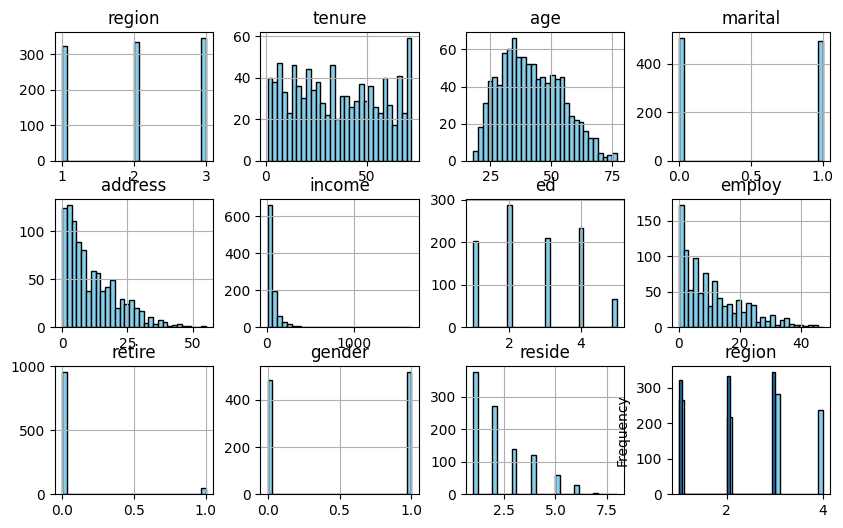

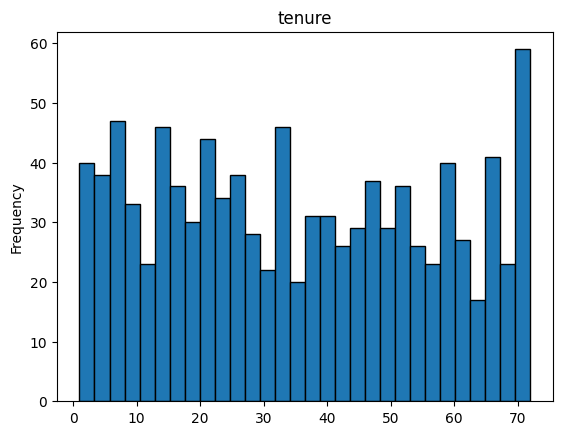

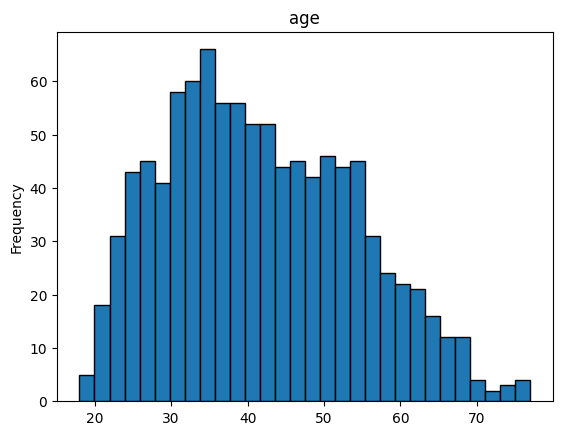

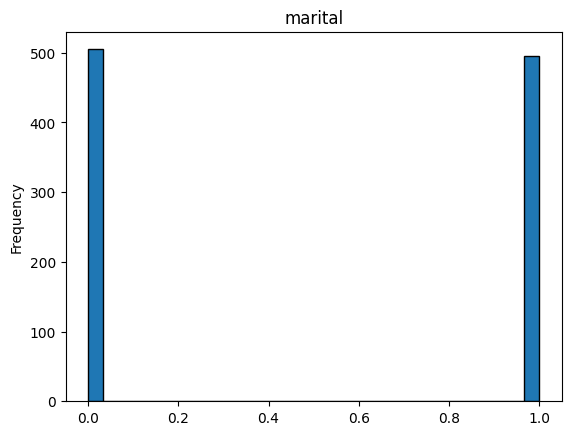

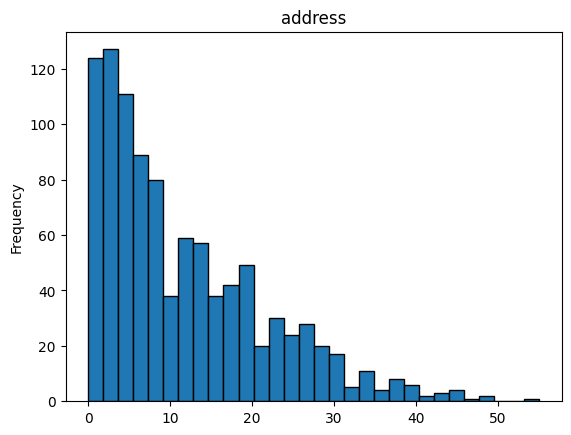

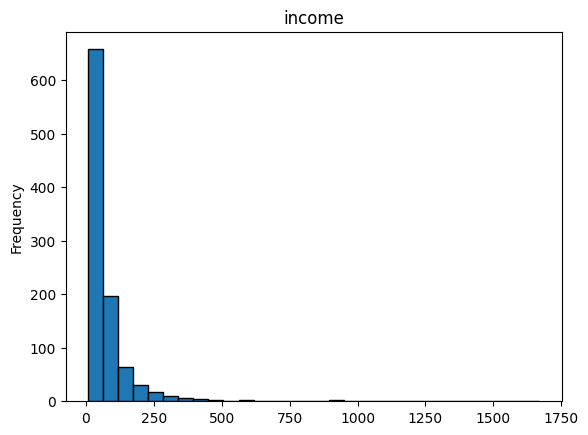

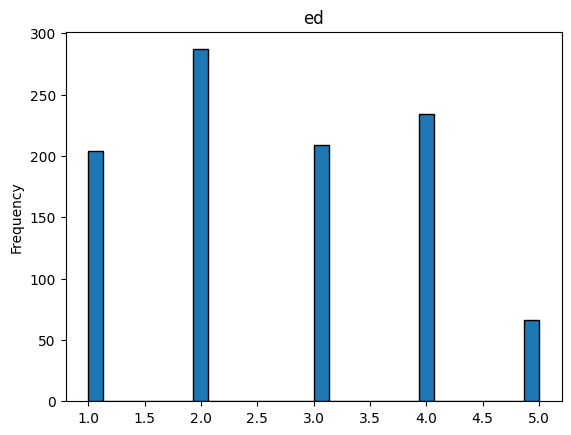

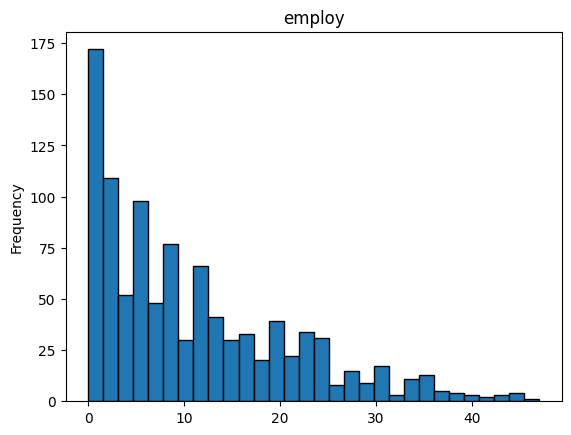

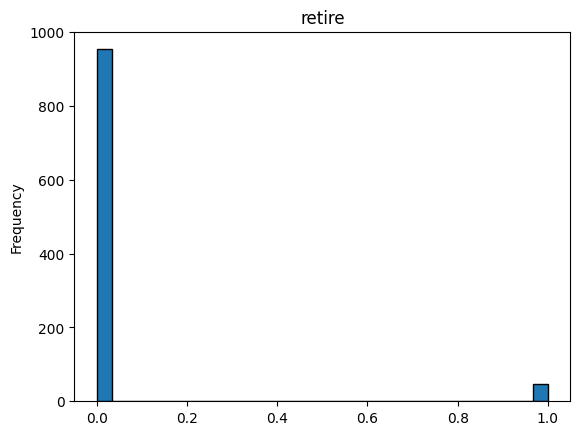

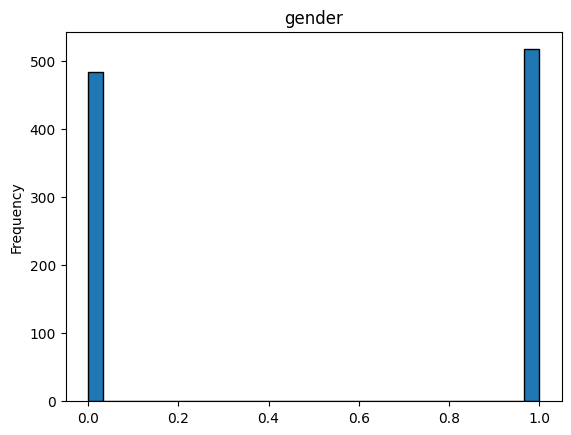

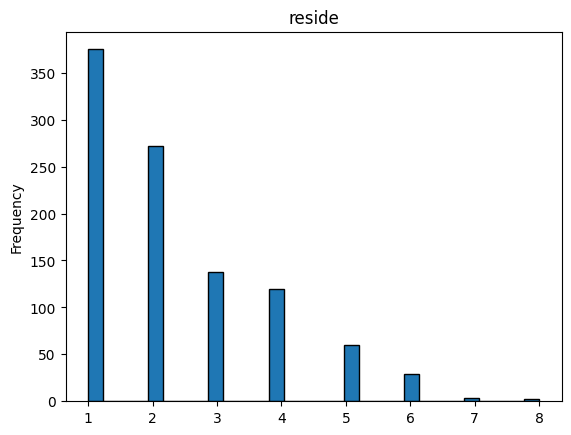

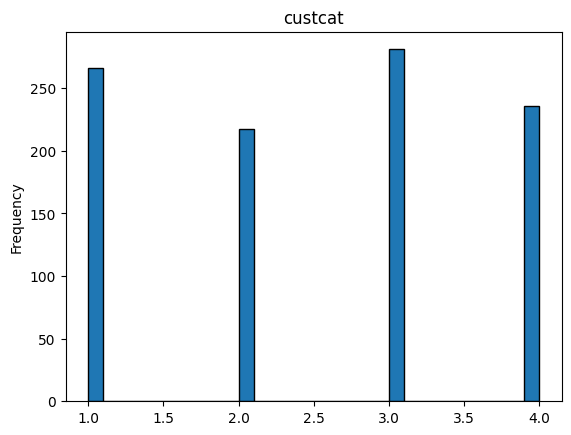

In [2]:
# Example plot: Histogram of numeric columns
telefonkunden.hist(figsize=(10, 6), bins=30, color='skyblue', edgecolor='black', layout=(3, 4))
import matplotlib.pyplot as plt

numeric_cols = telefonkunden.select_dtypes(include=['number']).columns
for col in numeric_cols:
    telefonkunden[col].plot(kind='hist', bins=30, edgecolor='black')
    plt.title(col)
    plt.show()

In [14]:
# - 2. den Datensatz in Trainings- und Lerndatensatz aufteilen

# Dafür erstellen wir zunächst (wie auch bei den Weinen) zwei separate Datensätze mit den Input- (X) und der Outputvariablen (Y).
X = telefonkunden.drop(columns=['custcat'])
Y = telefonkunden.custcat
X.head()
Y.head()

# Jetzt können wir wieder mit train_test_split aus scikit-learn den Datensatz in Trainings- und Testdaten aufteilen
from sklearn.model_selection import train_test_split

X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1, stratify = Y)
# Wie vorher: Wir teilen in 20% Lern- und 80% Testdaten auf (test_size), lassen die Aufteilung zur Reproduzierbarkeit der Ergebnisse immer gleich aufteilen (random_state), und sorgen im Trainingsdatensatz für den gleichen Anteil an Patienten mit und ohne Diabetes wie im gesamten Datensatz (stratify).

# Nun wird das Modelll trainiert. Wir verwenden zunächst k=3, d.h. wenn ein Testpunkt mindestens 2 von 3 nächste Nachbarn hat, die Diabetes (=1) haben, bekommt der Testpunkt das Label Diabetes (=1), wenn mindestens 2 der 3 nächsten Nachbarn kein Diabetes (=0) hat, bekommt der Testpunkt das Label kein Diabetes (=0).

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
vorhersage_scikit = knn.fit(X_training, Y_training)

In [15]:
# - 3. eine Vorhersage mit dem kNN-Algorithmus treffen
vorhersage_scikit=knn.predict(X_test)

In [16]:
# Am Ergebnisarray sieht man z.B. dass die ersten 4 Patienten im Testdatensatz vom Algorithmus als "kein Diabetes" klassifiziert wurde, der 5. Patient mit "Diabetes". Nun können wir wieder vergleichen, ob die jeweiligen Patienten im Testdatensatz tatsächlich Diabetes haben oder nicht, und ob das Modell dies richtig vorhergesagt hat. Dazu bedienen wir uns wieder dem Genauigkeits-Score, also dem Anteil richtiger Vorhersagen verglichen mit allen Vorhersagen.

from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test, vorhersage_scikit))

# Alternativ gibt es die Funktion score():
knn.score(X_test, Y_test)


0.335


0.335

In [17]:
# Die bisherige Vorgehensweise hieß Holdout-Methode: Man reserviert eine Menge als Testdaten, den Rest als Trainingsdaten. Allerdings kann dies zu Probleme führen: Vielleicht wurden die Daten unglücklich aufgeteilt?Zur Lösung bedient man sich der sog. k-fache Kreuzvalidierung, wie auch in der Vorlesung besprochen: Bei der Kreuzvalidierung wird der Datensatz zufällig in Gruppen aufgeteilt. Eine der Gruppen wird als Testsatz und der Rest als Trainingssatz verwendet. Das Modell wird mit dem Trainingssatz trainiert und mit dem Testsatz bewertet. Dann wird der Prozess wiederholt, bis jede einzelne Gruppe als Testsatz verwendet wurde. Bei der 5-fachen Kreuzvalidierung werden also die Daten in 5 Gruppen aufgeteilt und 5-mal angepasst und bewertet, wobei jedes Mal der Genauigkeitswert in einem Array abgespeichert wird. So hat jede der 5 Gruppen eine Chance, als Testdatensatz zu dienen.

import numpy as np
from sklearn.model_selection import cross_val_score

# Neuen Klassifikator verwenden, mit unserem idealen k=3
klassifikator_kreuzvalidierung = KNeighborsClassifier(n_neighbors=3)

# Genauigkeiten mit einem trainierten Modell mit 5 Gruppen
kreuzvalidierung_genauigkeiten = cross_val_score(klassifikator_kreuzvalidierung, X, Y, cv = 5)

# Genauigkeiten ausgeben
print(kreuzvalidierung_genauigkeiten)
# Nehmen wir einfach mal den Mittelwert dieser Genauigkeiten, und sehen, dass wir die Genauigkeit nochmals erhöhen konnten von ca. 66% auf ca. 71%!
print(np.mean(kreuzvalidierung_genauigkeiten))
# Wir konnten also eine Erhöhung der Genauigkeit erreichen!

[0.32  0.31  0.265 0.285 0.355]
0.307


In [ ]:
# Wir haben bisher k (also die Anzahl an nächsten Nachbarn, die der Algorithmus berücksichtigen soll) einfach geraten, hatten aber keinerlei Intuition, ob das ein guter Parameter für das Modell und die Daten ist. Was ist aus Sicht der Genauigkeit der Vorhersage ein optimales k? Dazu könnte man obigen Code für verschiedene k ausprobieren (egal ob eigener Code oder vorgefertigte Python-Funktion) und das k wählen, das die höchste Genauigkeit liefert. Ist aber sehr mühsam. Schreiben wir also eine Schleife, die für uns verschiedene k's in den knn-Algorithmus einsetzt, und uns anschließend dasjenige k liefert, bei dem die höchste Genauigkeit erreicht wird (sprich bei dem die meisten Patienten im Testdatensatz richtig klassifiziert werden). Dies nennt man wie im Skript besprochen "Hyperparameter-Optimierung".

# Dies kann man mit GridSearchCV erreichen. Damit wird das Modell mehrfach mit einer Reihe von Parametern trainiert, die eingegeben werden. Auf diese Weise kann das Modell mit jedem Parameter getestet und die optimalen Werte herausgefunden werden, um die besten Genauigkeitsergebnisse zu erhalten. 
# Dabei erstellt man zunächst ein Dictionary mit allen Werten von k, die einen interessieren (z.B. von 1 bis 100). Anschließend übergibt man jedes k einem neuen Klassifkiator KNeighborsClassifier. GridSearchCV ermittelt dann für eine gegebene Menge an Gruppen (z.B. 5 Gruppen mit 5 Vorhersagen, also 4 Trainings- und 1 Lerndatensatz, wobei jeder Datensatz über alle 5 Vorhersagen hinweg genau 1-mal Testdatensatz und genau 4-mal Trainingsdatensatz war). Jede dieser 5 Vorhersagen wird mit jedem Wert von k aus dem Dictionary durchgeführt. Bei 30 Werten für k und 5 Vorhersagen für jedes k wären dies also 100*5=500 Durchläufe, mit 500 Genauigkeits-Scores. GridSearchCV ermittelt daraus dann den höchsten Genauigkeits-Score, und schaut, bei welchem k dieser erreicht wurde. Dies ist dann unser optimales k für die Daten.

In [22]:
from sklearn.model_selection import GridSearchCV
# Definieren wir zunächst einen neuen Klassifikator:
knn2 = KNeighborsClassifier()

# Nun erstellen wir das Dictionary mit den k-Werten für die Hyperparameter-Optimimerung, die uns interessieren:
k_grid = {'n_neighbors': np.arange(1, 50)}

# Nun lassen wir die Grid-Suche für jedes k durchlaufen, jeweils mit einer 5-fachen Kreuzvalidierung:
knn_grid = GridSearchCV(knn2, k_grid, cv = 5)

# Nun trainieren wir das Modell mit den Daten und den darüber definierten Parametern:
knn_grid.fit(X, Y)

# Was ist nun die beste Anzahl an Nachbarn?
print(knn_grid.best_params_)

# Der Genauigkeits-Score bei dieser Anzahl an Nachbarn ist nochmal höher, wir sind von 37,5% auf 37,4% gekommen!
knn_grid.best_score_

{'n_neighbors': 42}


0.365

In [19]:
# Man kann die Funktion auch alle Genauigkeits-Scores ausgeben lassen. Dies sind also für jedes k die durchschnittlichen Werte der Genauigkeits-Scores aus je allen 5 Durchläufen der Kreuzvalidierung! Hier sieht man nochmals an der Stelle 14 den höchsten Score, und ebenfalls den bisherigen Score von 71%, den wir bei k=3 hatten!
scores=knn_grid.cv_results_['mean_test_score']
print(scores)

[0.291 0.301 0.307 0.312 0.31  0.316 0.312 0.323 0.326 0.329 0.327 0.33
 0.351 0.331 0.344 0.338 0.324 0.335 0.339 0.33  0.336 0.341 0.339 0.35
 0.35  0.35  0.348 0.358 0.353 0.351 0.35  0.342 0.354 0.353 0.343 0.35
 0.348 0.352 0.348 0.358 0.358 0.365 0.36  0.351 0.354 0.354 0.355 0.361
 0.361 0.353 0.355 0.357 0.36  0.359 0.359 0.357 0.361 0.357 0.359 0.36
 0.359 0.364 0.364 0.362 0.367 0.362 0.361 0.369 0.373 0.37  0.369 0.371
 0.364 0.371 0.369 0.364 0.365 0.368 0.373 0.37  0.368 0.368 0.369 0.374
 0.373 0.37  0.371 0.374 0.373 0.366 0.369 0.368 0.366 0.368 0.366 0.366
 0.368 0.369 0.368]


Text(0, 0.5, 'Genauigkeit')

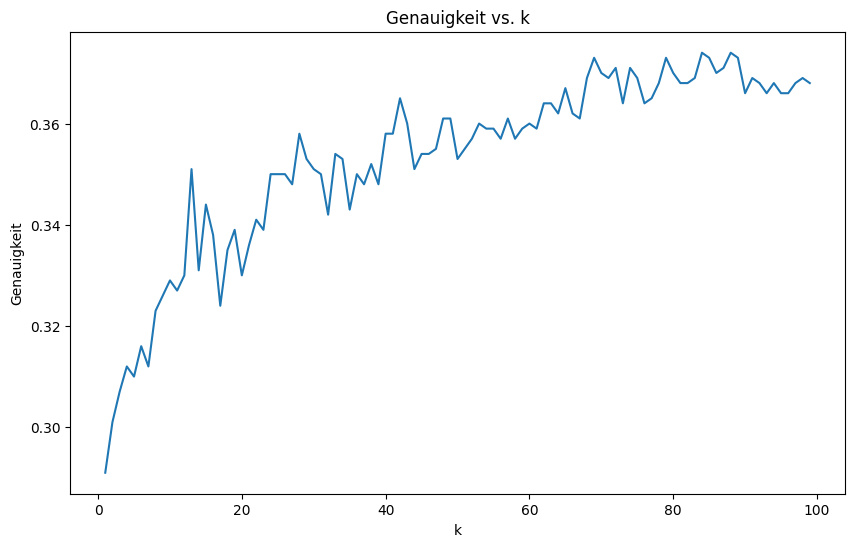

In [20]:
# Dies kann man auch noch grafisch darstellen. Dafür brauchen wir die matplotlib als gute Bibliothekt für Datenvisualisierung:
import matplotlib.pyplot as plt

# Wir definieren eine Bildgröße
plt.figure(figsize=(10,6))
# Wir plotten auf der x-Achse von 1 bis 60 (also die k's die wir oben in der for-Schleife durchprobiert haben)
plt.plot(range(1,100),scores)
# Wir beschriften noch die Achsen
plt.title('Genauigkeit vs. k')
plt.xlabel('k')
plt.ylabel('Genauigkeit')

In [ ]:
# Das Schaubild bestätigt unsere Vermutung aus dem Skript zu overfitting und underfitting:
# - Die Vorhersagegenauigkeit auf den Testdaten ist bei niederigen k schlecht, da in diesem Fall das Modell mit nur wenigen nächsten Nachbarn trainiert wurde, sodass die Genauigkeit in den Trainingsdaten zwar maximiert wurde, aber diese Vorhersagen eben nur auf den Trainingsdatensatz passen. Warum? Weil durch die kleinen k's auch zufälliges "Rauschen" (z.B. Ausreißer) als systematisch betrachtet wurden. Das Modell sagt daher für die Testdaten weniger genau voraus. Dies nennt man "overfitting"!
# - Die Vorhersagegenauigkeit auf den Testdaten ist bei hohen k schlecht, da in diesem Fall das Modell mit vielen nächsten Nachbarn trainiert wurde, sodass das Modell zu allgemein ist, und manche systematischen Bestandteile in den Daten nicht erkennt. Dies nennt man "underfitting"!
# - Nur bei einem mittleren k (hier 9 oder 10) schafft man einen Kompromiss aus overfitting und underfitting!

#Text von Höchenberger

In [47]:
!pip install imbalanced-learn

Beste Parameter: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Genauigkeit: 0.4
              precision    recall  f1-score   support

           1       0.44      0.47      0.45        53
           2       0.32      0.27      0.30        44
           3       0.42      0.50      0.46        56
           4       0.38      0.32      0.34        47

    accuracy                           0.40       200
   macro avg       0.39      0.39      0.39       200
weighted avg       0.39      0.40      0.40       200



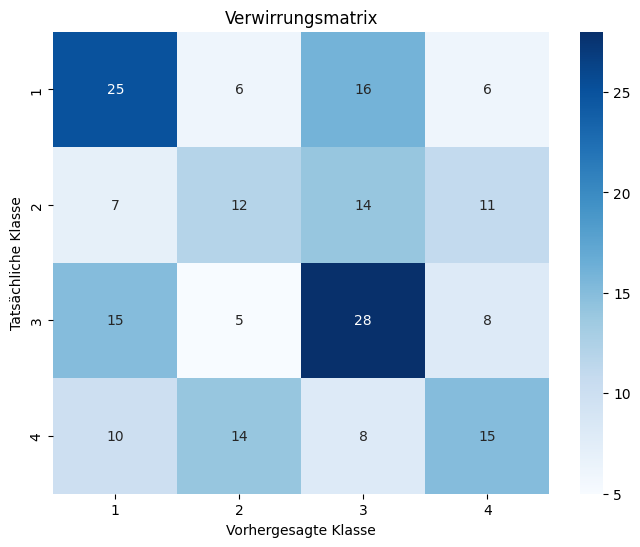

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Features und Zielvariable definieren
# Die Zielvariable 'custcat' wird für die Kundensegmentierung verwendet
X = df.drop(columns=['custcat'])
y = df['custcat']

# Daten normalisieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Grid Search zur Optimierung des RandomForest-Modells
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Bestes Modell auswählen
best_rf = grid_search.best_estimator_

# Vorhersagen treffen
y_pred = best_rf.predict(X_test)

# Modellbewertung
print("Beste Parameter:", grid_search.best_params_)
print("Genauigkeit:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Verwirrungsmatrix erstellen und visualisieren
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Tatsächliche Klasse')
plt.title('Verwirrungsmatrix')
plt.show()


Beste Parameter: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}
Genauigkeit: 0.31
              precision    recall  f1-score   support

           1       0.39      0.40      0.39        53
           2       0.26      0.25      0.25        44
           3       0.37      0.39      0.38        56
           4       0.18      0.17      0.18        47

    accuracy                           0.31       200
   macro avg       0.30      0.30      0.30       200
weighted avg       0.31      0.31      0.31       200



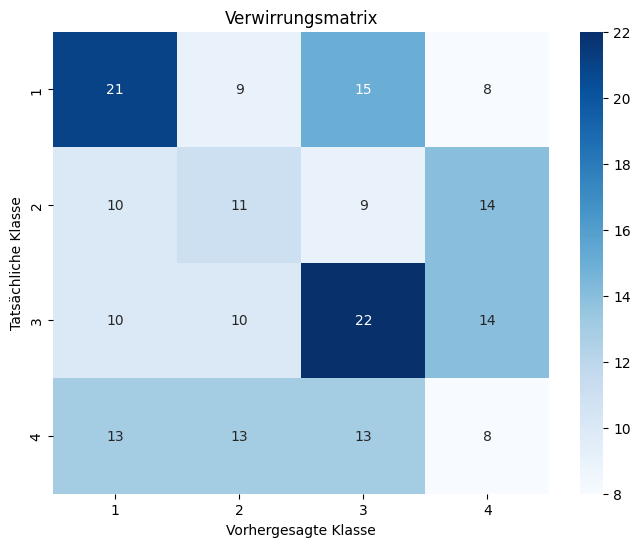

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Features und Zielvariable definieren
# Die Zielvariable 'custcat' wird für die Kundensegmentierung verwendet
X = df.drop(columns=['custcat'])
y = df['custcat']

# Daten normalisieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Grid Search zur Optimierung des Entscheidungsbaum-Modells
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Bestes Modell auswählen
best_dt = grid_search.best_estimator_

# Vorhersagen treffen
y_pred = best_dt.predict(X_test)

# Modellbewertung
print("Beste Parameter:", grid_search.best_params_)
print("Genauigkeit:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Verwirrungsmatrix erstellen und visualisieren
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Tatsächliche Klasse')
plt.title('Verwirrungsmatrix')
plt.show()
